In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

import matplotlib as mpl
import matplotlib.pylab as plt
# 한글깨짐 방지
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font',family=font_name)
# 마이너스 수식깨짐 방지
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
df_1 = pd.read_csv('C:/datafile/폐업_1.csv')
df_2 = pd.read_csv('C:/datafile/폐업_2.csv')
df_3 = pd.read_csv('C:/datafile/폐업_3.csv')
df_기타 = pd.read_csv('C:/datafile/폐업_기타.csv')
df_확진자 = pd.read_csv('C:/datafile/서울시 코로나19 확진자 현황.csv')

In [4]:
df_2.head(1)

,번호,개방서비스명,인허가일자,상세영업상태명,폐업일자,도로명전체주소,사업장명,좌표정보(x),좌표정보(y),시설규모
0,1,노래연습장업,2009-10-20,폐업,2021-02-05,"서울특별시 종로구 종로 125 (종로3가,대광빌딩 지층)",랑뽕,199183.4075,452042.972,NaN


In [55]:
#일자별 폐업수 산출, s : 산출 시작날짜 e : 산출 종료날짜
def closedate(df, s, e):
    df_cnt = df.groupby('폐업일자').count().iloc[:,0:1]
    df_날짜 = pd.to_datetime(list(map(str, df_cnt.index.to_list())))
    df_cnt.index = df_날짜
    df_cnt = df_cnt.reset_index()
    df_cnt.columns = ['폐업일자', '폐업수']
    d = pd.date_range(start = s, end = e)
    df_empty = pd.DataFrame(index = d).reset_index()
    df_empty.columns = ['폐업일자']
    
    df_result = pd.merge(df_empty, df_cnt, how = 'left', on = '폐업일자')
    df_result = df_result.fillna(0)
    df_result = df_result.rolling(14).mean().fillna(0)
    df_result.index = d
    df_result = df_result.reset_index()
    df_result.columns = ['폐업일자', '폐업수']
    
    return df_result

In [43]:
closedate(df_2, '20200101', '20210831').reset_index()

,index,폐업일자,폐업수
0,0,2020-01-01,0.000000
1,1,2020-01-02,0.000000
2,2,2020-01-03,0.000000
3,3,2020-01-04,0.000000
4,4,2020-01-05,0.000000
...,...,...,...
604,604,2021-08-27,57.857143
605,605,2021-08-28,58.000000
606,606,2021-08-29,58.428571
607,607,2021-08-30,58.285714


In [6]:
#폐업수 데이터 통합
def integrate(s, e, *args):
    df_new = closedate(args[0], s, e)
    for df in args[1:]:
        df_new = pd.merge(df_new, closedate(df, s, e), how = 'left', on = '폐업일자')
        
    return df_new

In [7]:
cols = ['폐업일자', '그룹1폐업수', '그룹2폐업수', '그룹3폐업수', '기타폐업수', '총폐업수']

In [52]:
df_폐업 = integrate('20200101', '20210831', df_1,df_2,df_3,df_기타)
df_폐업['총계'] = df_폐업.sum(axis = 1)
df_폐업.columns = cols
df_폐업

,폐업일자,그룹1폐업수,그룹2폐업수,그룹3폐업수,기타폐업수,총폐업수
0,2020-01-01,0.00,0.00,0.00,0.00,0.00
1,2020-01-02,0.00,0.00,0.00,0.00,0.00
2,2020-01-03,0.00,0.00,0.00,0.00,0.00
3,2020-01-04,0.00,0.00,0.00,0.00,0.00
4,2020-01-05,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...
604,2021-08-27,0.83,54.96,1.58,7.71,65.08
605,2021-08-28,0.82,53.94,1.57,7.54,63.87
606,2021-08-29,0.80,52.70,1.53,7.42,62.45
607,2021-08-30,0.81,53.61,1.53,7.60,63.55


In [45]:
#그룹별 시각화
def visual_group(df):
    l = df.shape[0]
    n = df.shape[1] - 1
    r = np.arange(l)
    d = list(map(str, df.폐업일자))
    df.폐업일자 = d
    df.폐업일자 = df.폐업일자.str[:10]
    fig = plt.figure(figsize = (20, 25))
    fig.subplots_adjust(hspace = 1)
    
    for i in range(1, n+1):
        ax = fig.add_subplot(n,1,i)
        ax.plot(r,df.iloc[:,i])
        
        if l < 30:
            plt.xticks(r, df.폐업일자, rotation = 45, fontsize = 10)
        else:
            plt.xticks(r[::l//20], df.폐업일자[::l//20], rotation = 45, fontsize = 10)
            
        plt.yticks(fontsize = 14)
        plt.xlabel('날짜')
        plt.ylabel('폐업수')
        plt.title(df.columns[i])

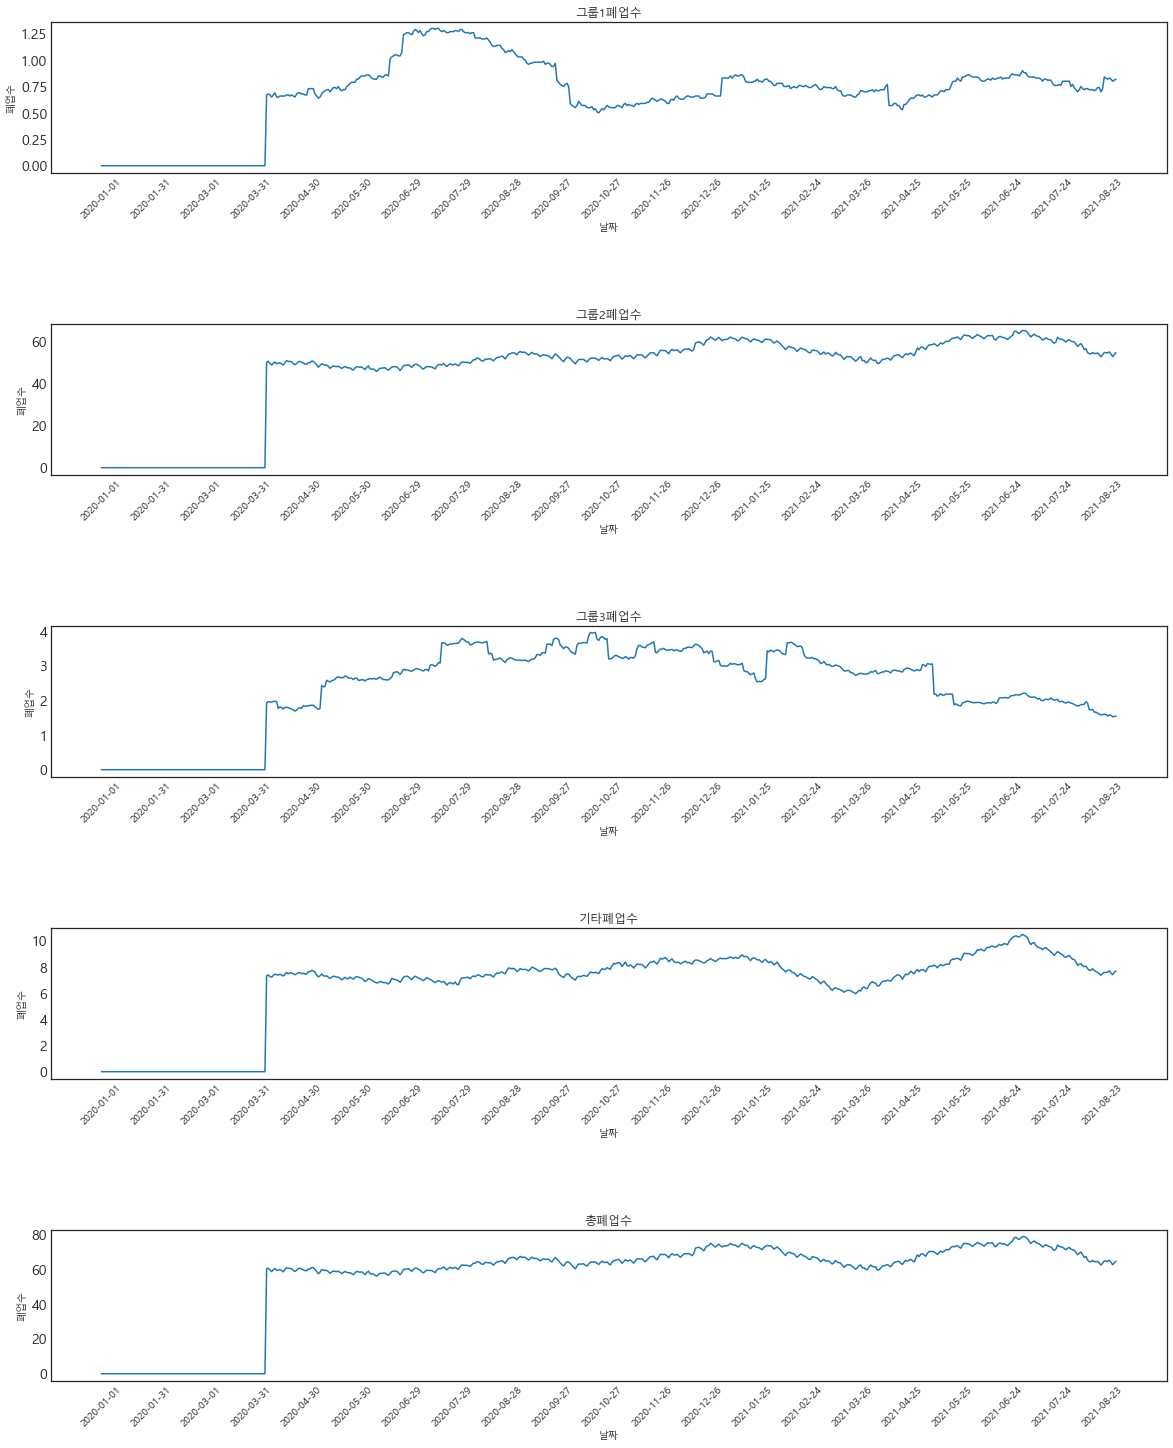

In [53]:
visual_group(df_폐업)

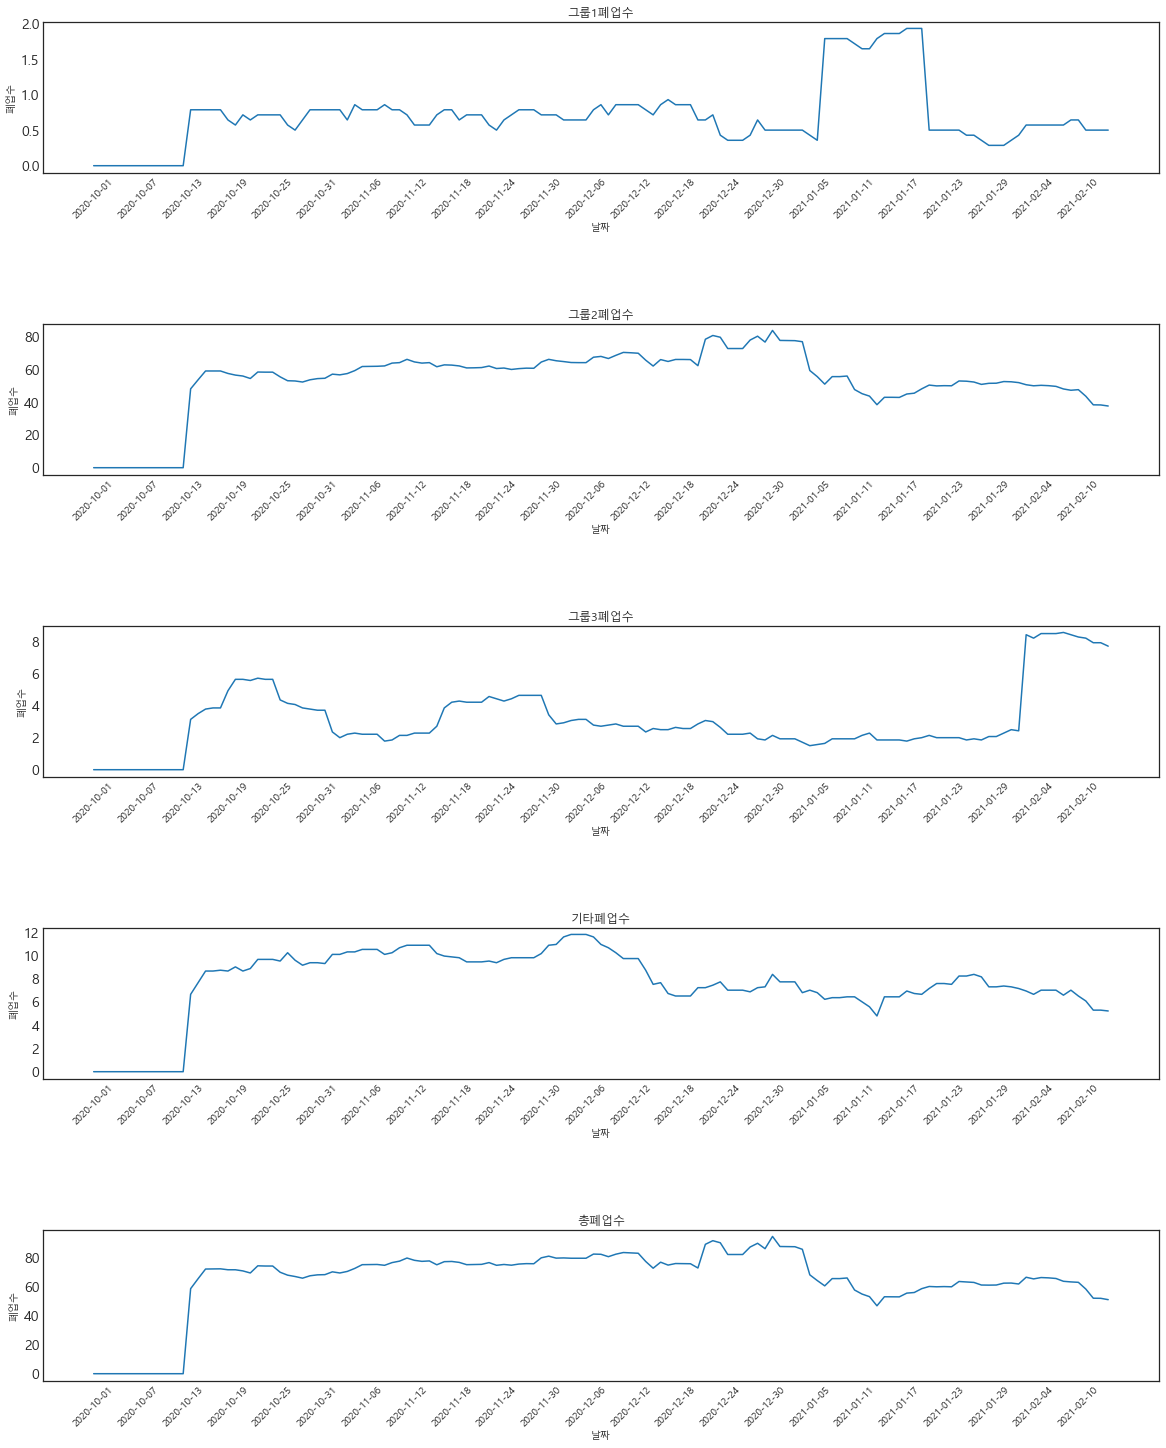

In [56]:
df_폐업3 = integrate('20201001', '20210214', df_1,df_2,df_3,df_기타)
df_폐업3['총계'] = df_폐업3.sum(axis = 1)
df_폐업3.columns = cols

visual_group(df_폐업3)

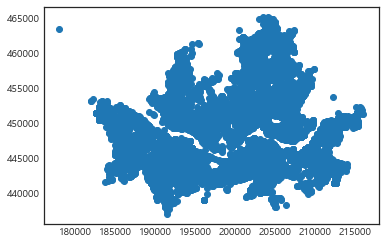

In [133]:
plt.scatter(df_2['좌표정보(x)'], df_2['좌표정보(y)'])

In [18]:
d = df_식품폐업.index.strftime("%Y%m%d").to_list()

df_식품폐업['날짜2'] = d

In [19]:
df_식품폐업['날짜3'] = df_식품폐업['날짜2'].str[:6].to_list()

In [20]:
l1 = ['202001','202002','202003','202004','202005','202006','202007','202008','202009','202010','202011','202012','202101','202102',
     '202103','202104','202105','202106','202107','202108','202109','202110','202111','202112']
l2 = ['20년01월', '20년02월', '20년03월', '20년04월', '20년05월', '20년06월', '20년07월', '20년08월', '20년09월', '20년10월', '20년11월',
     '20년12월', '21년01월', '21년02월', '21년03월', '21년04월', '21년05월', '21년06월', '21년07월', '21년08월', '21년09월', '21년10월',
     '21년11월', '21년12월']

In [21]:
df_식품폐업['년월'] = df_식품폐업['날짜3'].replace(l1, l2).to_list()


df_식품폐업 = df_식품폐업.drop(axis = 1, columns = ['날짜2', '날짜3'])

In [22]:
df_식품폐업_월별 = df_식품폐업.groupby('년월').sum()

Text(0.5, 1.0, '유흥폐업수')

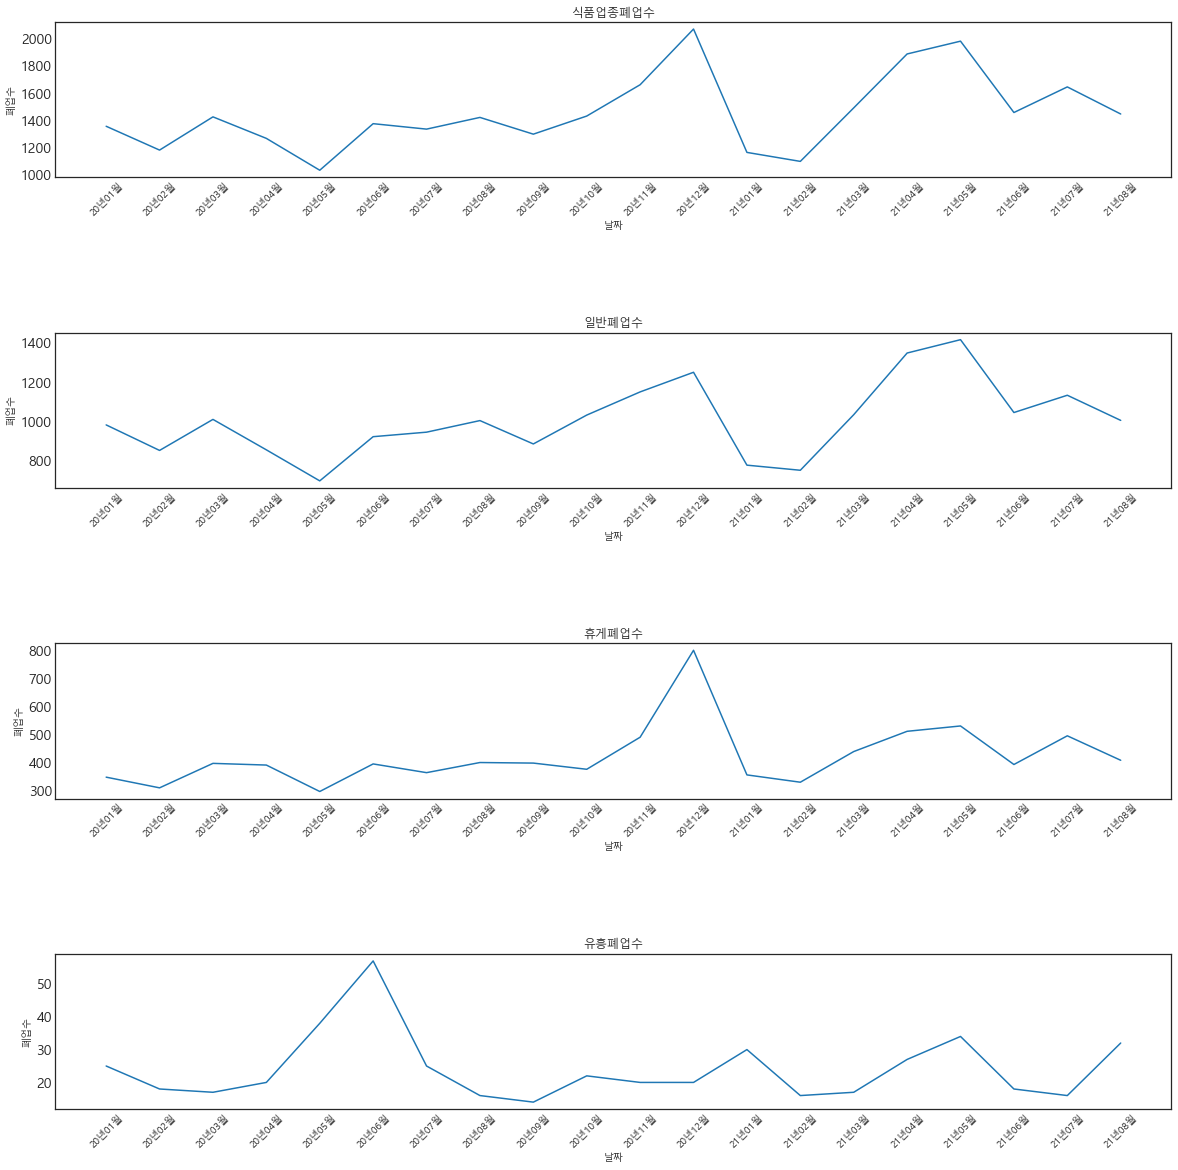

In [23]:
l = df_식품폐업_월별.shape[0]
r = np.arange(l)

fig = plt.figure(figsize = (20, 20))
fig.subplots_adjust(hspace = 1)

ax = fig.add_subplot(4,1,1)

ax.plot(r, df_식품폐업_월별['식품업종폐업수'])
plt.xticks(r, df_식품폐업_월별.index, rotation = 45 , fontsize = 10)
plt.yticks(fontsize = 14)
plt.xlabel('날짜')
plt.ylabel('폐업수')
plt.title('식품업종폐업수')


ax = fig.add_subplot(4,1,2)
ax.plot(r, df_식품폐업_월별['일반폐업수'])
plt.xticks(r, df_식품폐업_월별.index, rotation = 45 , fontsize = 10)
plt.yticks(fontsize = 14)
plt.xlabel('날짜')
plt.ylabel('폐업수')
plt.title('일반폐업수')

ax = fig.add_subplot(4,1,3)
ax.plot(r, df_식품폐업_월별['휴게폐업수'])
plt.xticks(r, df_식품폐업_월별.index, rotation = 45 , fontsize = 10)
plt.yticks(fontsize = 14)
plt.xlabel('날짜')
plt.ylabel('폐업수')
plt.title('휴게폐업수')

ax = fig.add_subplot(4,1,4)
ax.plot(r, df_식품폐업_월별['유흥폐업수'])
plt.xticks(r, df_식품폐업_월별.index,rotation = 45 , fontsize = 10)
plt.yticks(fontsize = 14)
plt.xlabel('날짜')
plt.ylabel('폐업수')
plt.title('유흥폐업수')

In [10]:
df_확진자 = pd.read_csv('C:/datafile/서울시 코로나19 확진자 현황.csv', parse_dates = ['확진일'])

In [20]:
df_확진자_cnt = df_확진자.groupby(by = '확진일').count().iloc[:,:1]
df_확진자_cnt.columns = ['확진자수']
df_확진자_cnt.head()

,확진자수
확진일,
2020-01-24,1
2020-01-30,3
2020-01-31,3
2020-02-02,1
2020-02-05,2


In [25]:
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
font= {'family' : font_name,
       'size' : 20}
matplotlib.rc('font', **font)
paramter = {'font.size': 20}

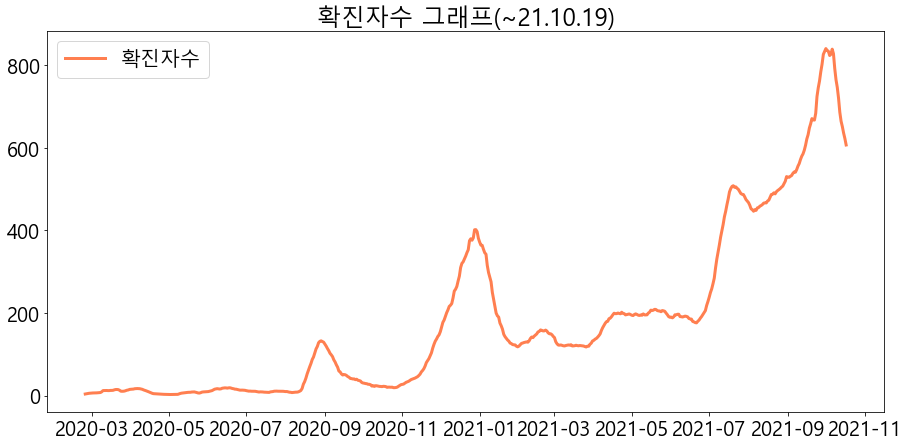

In [26]:
plt.figure(figsize =(15,7))
plt.plot(df_확진자_cnt.index,df_확진자_cnt['확진자수'].rolling(14).mean(),label='확진자수', color='#FF7F50', linewidth=3.0)
plt.title('확진자수 그래프(~21.10.19)')
plt.legend()